In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("loan_approval_dataset.csv")
df.columns = df.columns.str.strip()
print("Data shape:", df.shape)
df.head()


Data shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [3]:
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum())
print("\nBasic statistics for numeric columns:")
print(df.describe())
print("\nUnique values for key categorical columns (if they exist):")
for col in ["education", "self_employed", "loan_status"]:
    if col in df.columns:
        print(f"\nColumn: {col}")
        print(df[col].value_counts(dropna=False))


Columns: ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values per column:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Basic statistics for numeric columns:
           loan_id  no_of_dependents  income_annum   loan_amount    loan_term  \
count  4269.000000       4269.000000  4.269000e+03  4.269000e+03  4269.000000   
mean   2135.000000          2.498712  5.059124e+06  1.513345e+07    10.900445   
std    1232.498479          1.695910  2.8068

In [4]:
df["loan_status"] = df["loan_status"].astype(str).str.strip()

print("Unique values in loan_status before mapping:")
print(df["loan_status"].value_counts(dropna=False))
status_map = {"Approved": 1, "Rejected": 0}
df["loan_status"] = df["loan_status"].map(status_map)
df = df.dropna(subset=["loan_status"])
df["loan_status"] = df["loan_status"].astype(int)
print("\nClass distribution after mapping:")
print(df["loan_status"].value_counts())
print("\nClass ratio (Approved / Rejected):")
print(df["loan_status"].value_counts(normalize=True))


Unique values in loan_status before mapping:
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Class distribution after mapping:
loan_status
1    2656
0    1613
Name: count, dtype: int64

Class ratio (Approved / Rejected):
loan_status
1    0.62216
0    0.37784
Name: proportion, dtype: float64


In [5]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != "loan_status"]
print("Numeric columns:", numeric_cols)
possible_asset_cols = [
    "residential_assets_value",
    "commercial_assets_value",
    "luxury_assets_value",
    "bank_asset_value"
]
for col in possible_asset_cols:
    if col in df.columns:
        print(f"\n{col} - min: {df[col].min()}, max: {df[col].max()}")
for col in numeric_cols:
    if (df[col] < 0).any():
        neg_count = (df[col] < 0).sum()
        print(f"Column '{col}' has {neg_count} negative values (potentially invalid).")


Numeric columns: ['loan_id', 'no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']

residential_assets_value - min: -100000, max: 29100000

commercial_assets_value - min: 0, max: 19400000

luxury_assets_value - min: 300000, max: 39200000

bank_asset_value - min: 0, max: 14700000
Column 'residential_assets_value' has 28 negative values (potentially invalid).


In [6]:
for col in possible_asset_cols:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)
for col in numeric_cols:
    q1 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df[col] = df[col].clip(lower=q1, upper=q99)
print("Finished basic cleaning (negative values & extreme outliers clipped).")


Finished basic cleaning (negative values & extreme outliers clipped).


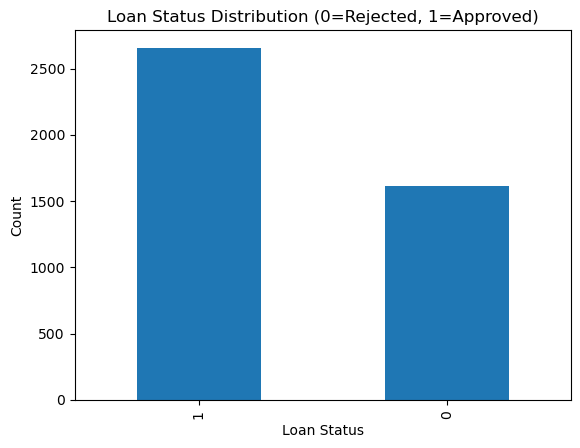

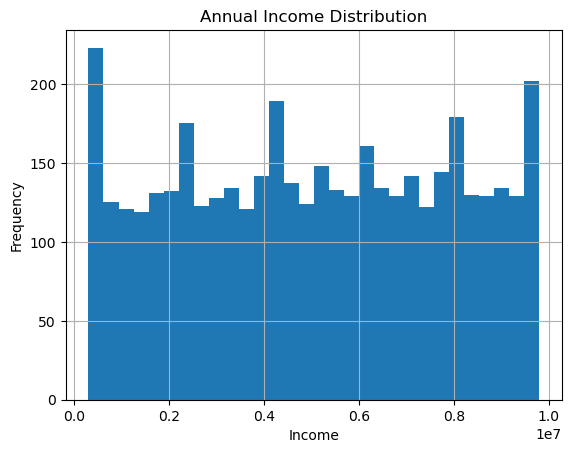

<Figure size 640x480 with 0 Axes>

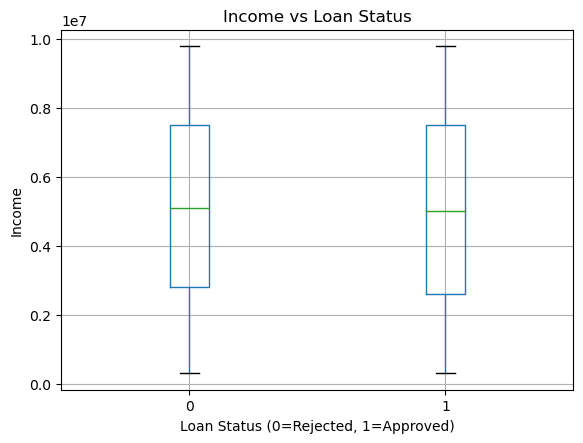

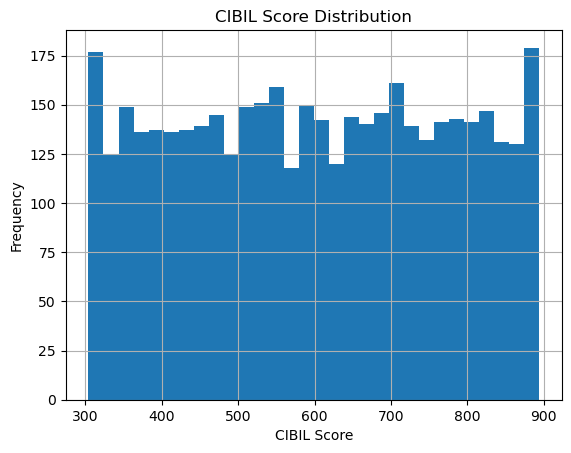

<Figure size 640x480 with 0 Axes>

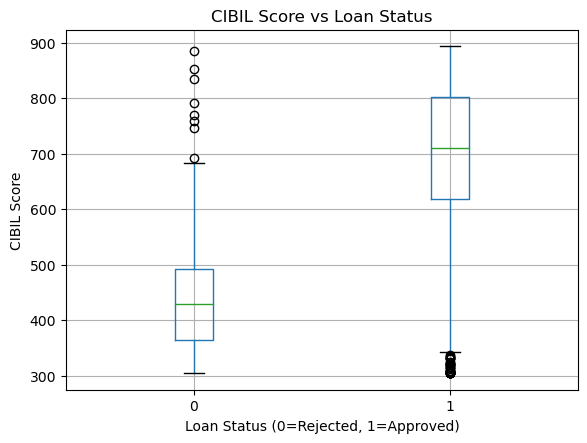

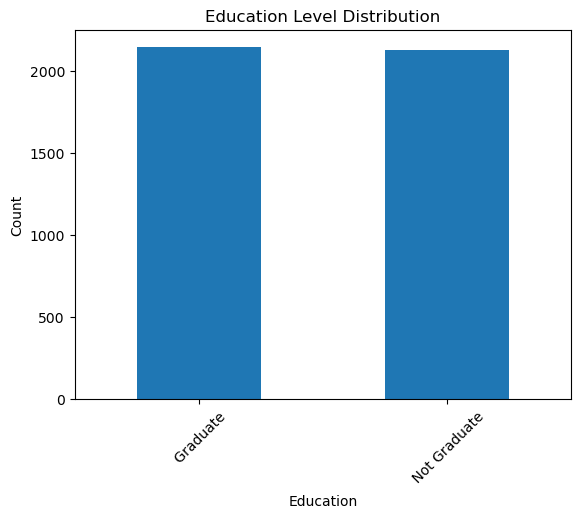

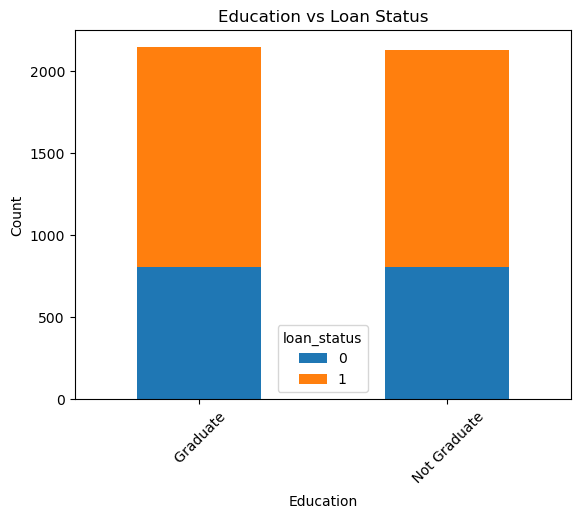

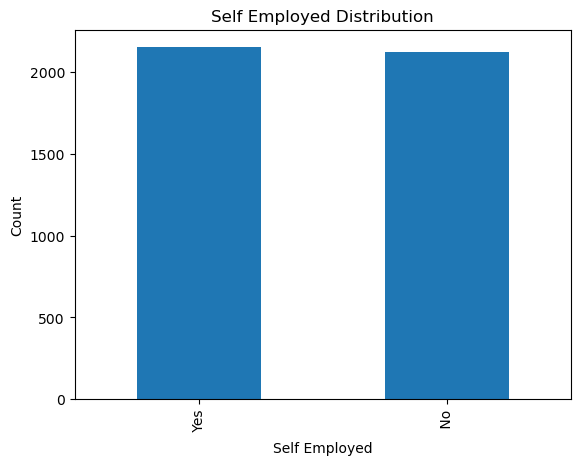

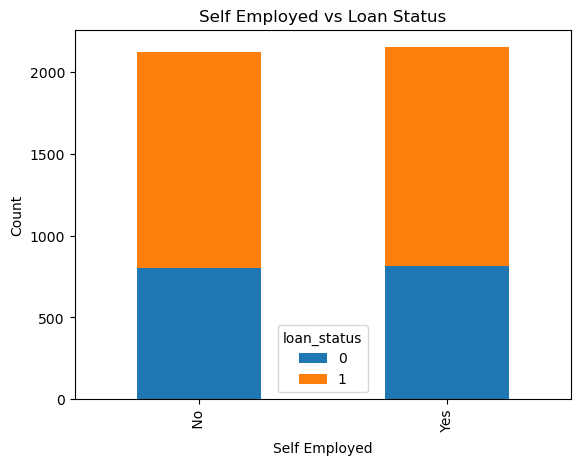

In [7]:
plt.style.use("default")

plt.figure()
df["loan_status"].value_counts().plot(kind="bar")
plt.title("Loan Status Distribution (0=Rejected, 1=Approved)")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.show()
if "income_annum" in df.columns:
    plt.figure()
    df["income_annum"].hist(bins=30)
    plt.title("Annual Income Distribution")
    plt.xlabel("Income")
    plt.ylabel("Frequency")
    plt.show()
    plt.figure()
    df.boxplot(column="income_annum", by="loan_status")
    plt.title("Income vs Loan Status")
    plt.suptitle("")  # remove default title
    plt.xlabel("Loan Status (0=Rejected, 1=Approved)")
    plt.ylabel("Income")
    plt.show()
if "cibil_score" in df.columns:
    plt.figure()
    df["cibil_score"].hist(bins=30)
    plt.title("CIBIL Score Distribution")
    plt.xlabel("CIBIL Score")
    plt.ylabel("Frequency")
    plt.show()

    plt.figure()
    df.boxplot(column="cibil_score", by="loan_status")
    plt.title("CIBIL Score vs Loan Status")
    plt.suptitle("")
    plt.xlabel("Loan Status (0=Rejected, 1=Approved)")
    plt.ylabel("CIBIL Score")
    plt.show()
if "education" in df.columns:
    plt.figure()
    df["education"].value_counts().plot(kind="bar")
    plt.title("Education Level Distribution")
    plt.xlabel("Education")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
    edu_status = pd.crosstab(df["education"], df["loan_status"])
    edu_status.plot(kind="bar", stacked=True)
    plt.title("Education vs Loan Status")
    plt.xlabel("Education")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()
if "self_employed" in df.columns:
    plt.figure()
    df["self_employed"].value_counts().plot(kind="bar")
    plt.title("Self Employed Distribution")
    plt.xlabel("Self Employed")
    plt.ylabel("Count")
    plt.show()

    se_status = pd.crosstab(df["self_employed"], df["loan_status"])
    se_status.plot(kind="bar", stacked=True)
    plt.title("Self Employed vs Loan Status")
    plt.xlabel("Self Employed")
    plt.ylabel("Count")
    plt.show()


In [8]:
for col in ["loan_id", "id", "ID"]:
    if col in df.columns:
        df = df.drop(columns=[col])

target_col = "loan_status"
X = df.drop(columns=[target_col])
y = df[target_col]
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical features: ['education', 'self_employed']


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class distribution:")
print(y_train.value_counts(normalize=True))
print("Test class distribution:")
print(y_test.value_counts(normalize=True))


Train shape: (3415, 11) Test shape: (854, 11)
Train class distribution:
loan_status
1    0.622255
0    0.377745
Name: proportion, dtype: float64
Test class distribution:
loan_status
1    0.62178
0    0.37822
Name: proportion, dtype: float64


In [10]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [11]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",  
    solver="lbfgs"
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

gb_clf = GradientBoostingClassifier(
    random_state=42
)
pipe_log_reg = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

pipe_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", rf_clf)
])

pipe_gb = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", gb_clf)
])


In [12]:
def evaluate_classifier(model, X_train, y_train, X_test, y_test, model_name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        y_prob = None
        roc_auc = None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"\n==== {model_name} ====")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))
    print("F1-score :", round(f1, 4))
    if roc_auc is not None:
        print("ROC-AUC  :", round(roc_auc, 4))
    
    print("\nClassification report:")
    print(classification_report(y_test, y_pred, zero_division=0))
    
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    if y_prob is not None:
        RocCurveDisplay.from_predictions(y_test, y_prob)
        plt.title(f"ROC Curve - {model_name}")
        plt.show()
    
    return {
        "model_name": model_name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc_auc
    }



==== Logistic Regression ====
Accuracy : 0.9239
Precision: 0.9551
Recall   : 0.9209
F1-score : 0.9377
ROC-AUC  : 0.9735

Classification report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       323
           1       0.96      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.92      0.92       854

Confusion matrix:
[[300  23]
 [ 42 489]]


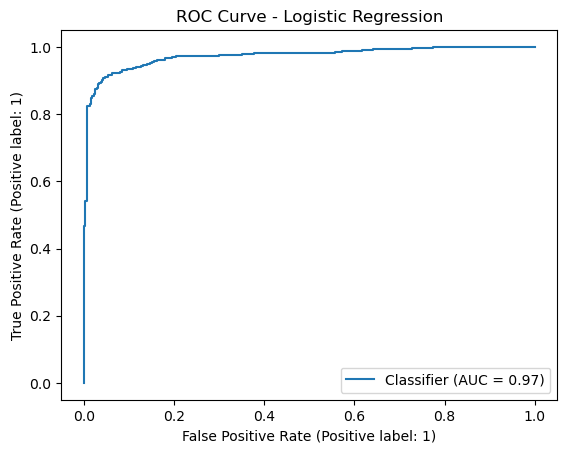


==== Random Forest ====
Accuracy : 0.9813
Precision: 0.9813
Recall   : 0.9887
F1-score : 0.985
ROC-AUC  : 0.9987

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.98       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

Confusion matrix:
[[313  10]
 [  6 525]]


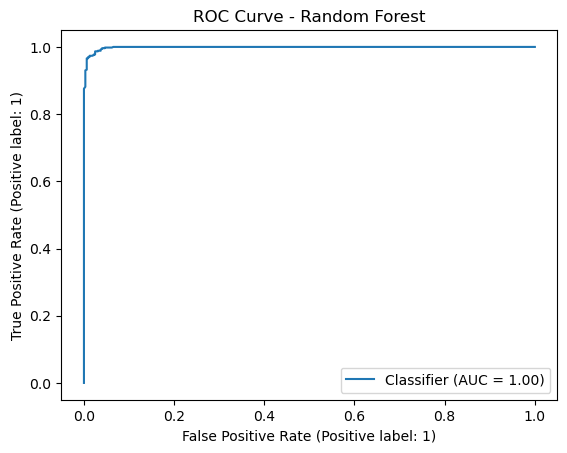


==== Gradient Boosting ====
Accuracy : 0.9824
Precision: 0.9831
Recall   : 0.9887
F1-score : 0.9859
ROC-AUC  : 0.998

Classification report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

Confusion matrix:
[[314   9]
 [  6 525]]


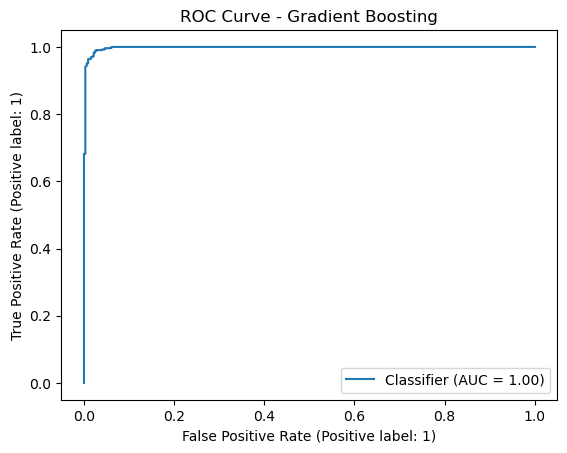

,model_name,accuracy,precision,recall,f1,roc_auc
0,Logistic Regression,0.923888,0.955078,0.920904,0.937680,0.973483
1,Random Forest,0.981265,0.981308,0.988701,0.984991,0.998674
2,Gradient Boosting,0.982436,0.983146,0.988701,0.985915,0.997980


In [13]:
results = []

res_lr = evaluate_classifier(pipe_log_reg, X_train, y_train, X_test, y_test, "Logistic Regression")
results.append(res_lr)

res_rf = evaluate_classifier(pipe_rf, X_train, y_train, X_test, y_test, "Random Forest")
results.append(res_rf)

res_gb = evaluate_classifier(pipe_gb, X_train, y_train, X_test, y_test, "Gradient Boosting")
results.append(res_gb)
results_df = pd.DataFrame(results)
results_df


In [14]:
def get_feature_names(column_transformer):
    """
    Get feature names from ColumnTransformer (numeric + one-hot encoded categorical).
    """
    output_features = []
    for name, trans, cols in column_transformer.transformers_:
        if name == "num":
            output_features.extend(cols)
        elif name == "cat":
            ohe = trans.named_steps["onehot"]
            cat_cols = cols
            ohe_features = ohe.get_feature_names_out(cat_cols)
            output_features.extend(ohe_features)

    return output_features
preprocessor.fit(X_train)
feature_names = get_feature_names(preprocessor)
len(feature_names), feature_names[:10]


(13,
 ['no_of_dependents',
  'income_annum',
  'loan_amount',
  'loan_term',
  'cibil_score',
  'residential_assets_value',
  'commercial_assets_value',
  'luxury_assets_value',
  'bank_asset_value',
  'education_ Graduate'])

Top 15 important features - Random Forest:
cibil_score                 0.802454
loan_term                   0.050201
loan_amount                 0.031252
residential_assets_value    0.020272
luxury_assets_value         0.020272
income_annum                0.019601
commercial_assets_value     0.019429
bank_asset_value            0.017390
no_of_dependents            0.009862
education_ Not Graduate     0.002375
education_ Graduate         0.002370
self_employed_ Yes          0.002299
self_employed_ No           0.002222
dtype: float64


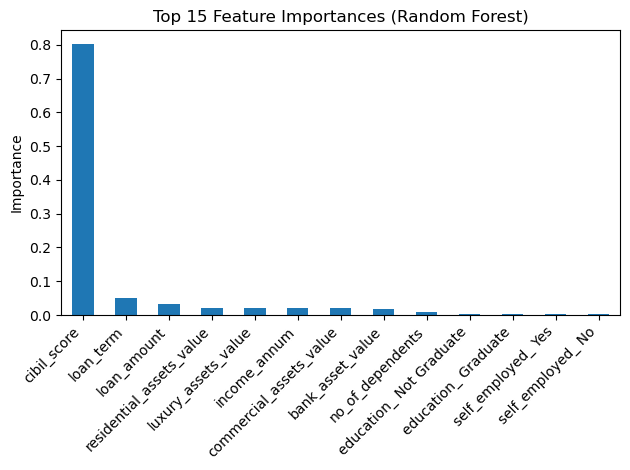

Top 15 important features - Gradient Boosting:
cibil_score                 8.649525e-01
loan_term                   9.789408e-02
loan_amount                 1.947033e-02
income_annum                1.093797e-02
luxury_assets_value         2.421011e-03
residential_assets_value    2.072145e-03
commercial_assets_value     1.610583e-03
no_of_dependents            3.957626e-04
bank_asset_value            2.349316e-04
education_ Not Graduate     6.567777e-06
education_ Graduate         4.037255e-06
self_employed_ Yes          3.906843e-08
self_employed_ No           0.000000e+00
dtype: float64


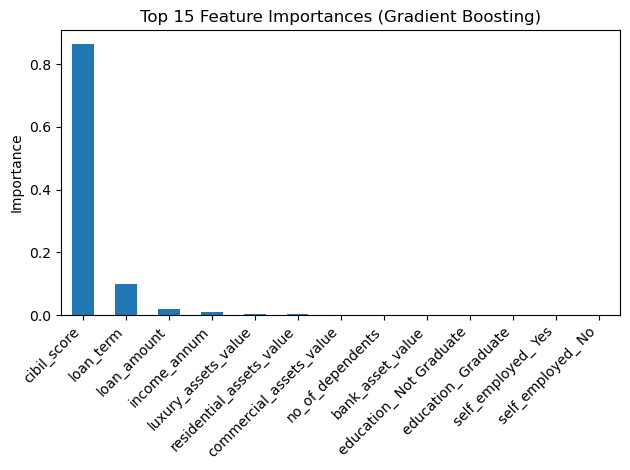

In [15]:
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)
rf_for_importance = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)
rf_for_importance.fit(X_train_transformed, y_train)

importances_rf = rf_for_importance.feature_importances_
feat_imp_rf = pd.Series(importances_rf, index=feature_names).sort_values(ascending=False)

print("Top 15 important features - Random Forest:")
print(feat_imp_rf.head(15))

plt.figure()
feat_imp_rf.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()
gb_for_importance = GradientBoostingClassifier(random_state=42)
gb_for_importance.fit(X_train_transformed, y_train)

importances_gb = gb_for_importance.feature_importances_
feat_imp_gb = pd.Series(importances_gb, index=feature_names).sort_values(ascending=False)
print("Top 15 important features - Gradient Boosting:")
print(feat_imp_gb.head(15))
plt.figure()
feat_imp_gb.head(15).plot(kind="bar")
plt.title("Top 15 Feature Importances (Gradient Boosting)")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [16]:
for name, pipe in [
    ("Logistic Regression", pipe_log_reg),
    ("Random Forest", pipe_rf),
    ("Gradient Boosting", pipe_gb),
]:
    cv_scores = cross_val_score(pipe, X, y, cv=5, scoring="f1")
    print(f"{name} - CV F1 scores: {cv_scores}, Mean: {cv_scores.mean():.4f}")


Logistic Regression - CV F1 scores: [0.93756004 0.93294461 0.93307468 0.94433781 0.92664093], Mean: 0.9349
Random Forest - CV F1 scores: [0.98409729 0.98327138 0.98774741 0.98327138 0.98681733], Mean: 0.9850
Gradient Boosting - CV F1 scores: [0.98215962 0.9823584  0.98781631 0.98397738 0.98681733], Mean: 0.9846
